# 前置作業
- [競賽網站點我](http://140.116.52.202:5566/)
- import base package
- load dataset
- data preprocessing

In [23]:
import pandas as pd
import numpy as np
import os
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [24]:
train_data, test_data = {}, {}
for i in range(1, 8):
    train_data["data{}".format(i)] = pd.read_csv("./data/data{}/train.csv".format(i), header=None)
    test_data["data{}".format(i)]  = pd.read_csv("./data/data{}/test.csv".format(i), header=None)

In [25]:
for data in train_data:
    df = train_data[data]
    print(data, ':', df.shape)

data1 : (765, 9)
data2 : (574, 9)
data3 : (371, 14)
data4 : (6064, 9)
data5 : (7077, 5)
data6 : (1187, 12)
data7 : (231, 7)


## 將缺少過多資料的 row 移除 (每個資料移除 10% 以下)

In [26]:
for data in train_data:
    df = train_data[data]
    # 計算每 row 的缺少值
    count = [0 for _ in range(df.shape[1])] 
    for row in range(df.shape[0]):
        missing_count = df.iloc[row, :-1].isnull().sum()
        count[missing_count] += 1  
        
    percent = [round(x/df.shape[0]*100, 2) for x in count]
    #display(pd.DataFrame({data:count, '%':percent}).transpose())
    percent_cum = np.cumsum(percent[::-1])[::-1] # reverse the list and do cumulation
    
    # remove task
    for num in range(df.shape[0]):
        if percent_cum[num] < 11: # 移除小於 11% 資料比例，決定移除缺少超過 `num` 個的 row
            for row in range(df.shape[0]):
                missing_count = df.iloc[row, :-1].isnull().sum()
                if missing_count >= num:
                    train_data[data] = train_data[data].drop(df.index[[row]])
            train_data[data] = train_data[data].reset_index(drop=True)
            break

In [27]:
# 移除後的資料 shape
for data in train_data:
    df = train_data[data]
    print(data, ':', df.shape)

data1 : (725, 9)
data2 : (539, 9)
data3 : (354, 14)
data4 : (5717, 9)
data5 : (6484, 5)
data6 : (1105, 12)
data7 : (211, 7)


## heat map
從熱圖中可以看到，有些變數與 y 值非常相關。  
因此，希望能新增一項門檻讓那些有較高相關係數的變數放在 Regressor 預測。

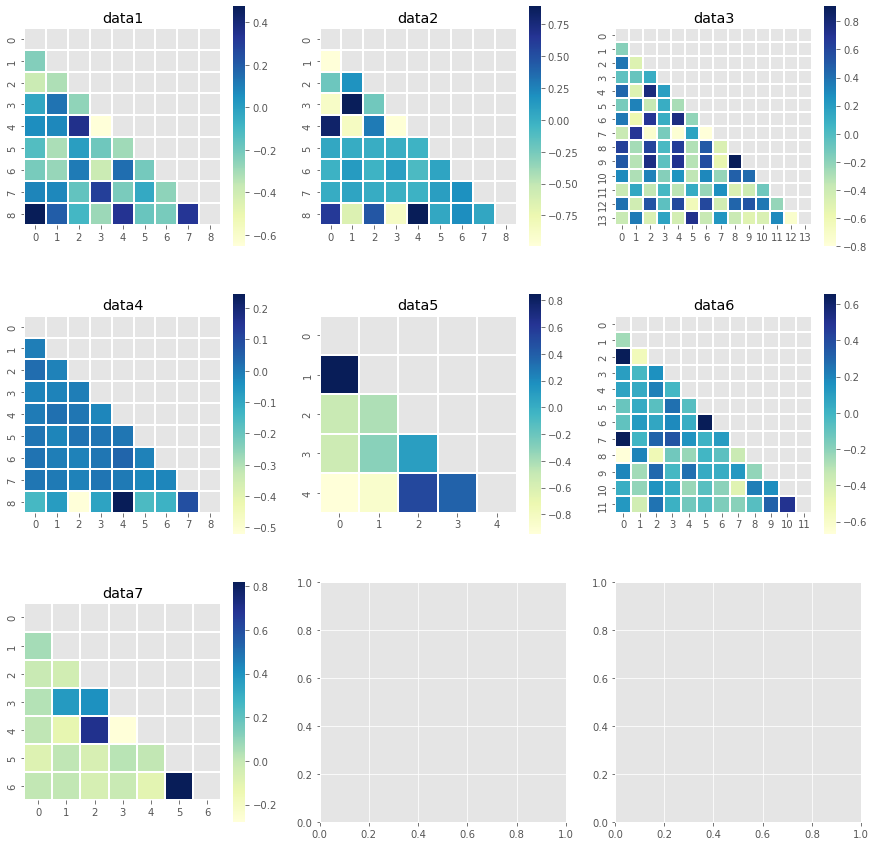

In [28]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 15))
for i, data in enumerate(train_data):
    df = train_data[data]
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool_)
    mask[np.triu_indices_from(mask)] = True
    ax1 = sns.heatmap(corr, xticklabels=corr.columns, mask=mask, yticklabels=corr.columns, 
                      square=True, linewidths=.2, cmap="YlGnBu", ax=axes[i//3][i%3])
    ax1.set_title("{}".format(data))

## 轉換 nunique <= 20 做 Label Encoding

In [29]:
label_col, non_label_col = {}, {}  # 紀錄轉為標記 / 非標記的欄位
label_dict = {}  # 紀錄轉換 Label 前後的值

for data in train_data:
    print(data)
    df = train_data[data].copy()
    unique_num = df.nunique()
    label_col[data], non_label_col[data] = [], []  # 建立目前 data 的空清單
    label_dict[data] = {}  # 建立目前 data Label 的空字典
    
    # 計算與 y 的相關係數，並選取有高相關的欄位做 Regressor
    corr = df.corr().loc[df.shape[1]-1, :df.shape[1]-2].abs() # 
    linear_col = np.where(corr > 0.8)[0]
    
    for col in range(df.shape[1]):
        unique_item = df.iloc[:, col].unique()
        unique_item = sorted(unique_item[~np.isnan(unique_item)]) # 排序並移除 nan
        
        # 將少於 (?) 個值的欄位視為有序變數，並轉換 Label
        if (unique_num[col] <= 20) and (col not in linear_col):
            label_col[data].append(col) # 登入標記欄位
            label_dict[data]['col{}'.format(col)] = {}  # 建立目前 欄位 的空字典
            
            for j in range(unique_num[col]):
                to_replace = np.where(df.iloc[:, col]==unique_item[j])[0]
                train_data[data].loc[to_replace, col] = j
                # 登入此 unique_item 轉換為 j 標記
                label_dict[data]['col{}'.format(col)][unique_item[j]] = j  
        
        elif col != (df.shape[1]):
            non_label_col[data].append(col) # 登入非標記欄位

data1
data2
data3
data4
data5
data6
data7


In [30]:
# 七個資料集，各自登記使用 Label Encoding 欄位
label_col

{'data1': [7],
 'data2': [0, 1, 2, 5, 6, 7],
 'data3': [3, 8],
 'data4': [],
 'data5': [],
 'data6': [11],
 'data7': [0, 1, 2, 3, 4]}

In [31]:
# 七個資料集，各自登記 "不" 使用 Label Encoding 欄位
non_label_col

{'data1': [0, 1, 2, 3, 4, 5, 6, 8],
 'data2': [3, 4, 8],
 'data3': [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13],
 'data4': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'data5': [0, 1, 2, 3, 4],
 'data6': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'data7': [5, 6]}

In [32]:
# 為 test data 做 Label Encoding 轉換
for data in test_data:
    print(data)
    df = test_data[data].copy()

    for col in label_col[data]:
        label_transfer_list = label_dict[data]['col{}'.format(col)]
        test_data[data].iloc[:, col] = df.iloc[:, col].replace(label_transfer_list)

data1
data2
data3
data4
data5
data6
data7


# Fill The Missing Value
最後一欄 y 沒有缺失值，希望能用在每一次的預測中。

## KNN
- [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
- 使用 IterativeImputer 配合模型，將連續及有序資料變數區分開來進行預測
- 限制: IterativeImputer 使用 Classifier 無法套用連續變數

In [33]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
# construct model
imputer_Regressor = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=15,
                                                                   weights='distance'), 
                                      random_state=0, max_iter=30)

imputer_Classifier = IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=15,
                                                                     weights='distance', 
                                                                     leaf_size=50), 
                                      random_state=0, max_iter=30)
clf = KNeighborsClassifier(weights='distance', leaf_size=50)

train_KNNfill, test_KNNfill = {}, {}
for data in train_data:
    print(data)
    
    # 引入需要處理的 data 資料
    df, df_test = train_data[data].copy(), test_data[data].copy()
    r_index, c_index = non_label_col[data].copy(), label_col[data].copy()
    y_index = df.shape[1]-1

    # 從兩個 index 中移除最後一欄 y
    r_index = [x for x in r_index if x!=(y_index)]
    c_index = [x for x in c_index if x!=(y_index)]
    
    # 如果 category 多過 continuous, 那就先填 category 的 NA
    # 接著用全部資料執行 Regressor
    if len(c_index) > len(r_index): 
        if c_index != []: 
            print('* Do the Classification. -- train')
            df_X = df.iloc[:, c_index] # 加入 y 欄位
            imputer_Classifier.fit(df_X)  # 使用 train data 去 fit  
            df_impute = pd.DataFrame(imputer_Classifier.transform(df_X))
            for i in range(len(c_index)):
                df.iloc[:, c_index[i]] = df_impute.iloc[:, i]
            
            print('* Do the Classification. -- test')
            imputer_Classifier.fit(df.iloc[:, c_index])  # 使用填好的 train data 去 refit  
            df_Xt = df_test.iloc[:, c_index]
            df_impute = pd.DataFrame(imputer_Classifier.transform(df_Xt))
            for i in range(len(c_index)):
                df_test.iloc[:, c_index[i]] = df_impute.iloc[:, i]
        
        if r_index != []: 
            print('* Do the Regression. -- train')
            #df_X = df.iloc[:, :-1]  
            imputer_Regressor.fit(df)   # 使用全部的 train data 去 fit  
            df_impute = pd.DataFrame(imputer_Regressor.transform(df))
            for i in range(len(r_index)):
                df.iloc[:, r_index[i]] = df_impute.iloc[:, r_index[i]]
            
            print('* Do the Regression. -- test')
            imputer_Regressor.fit(df.iloc[:, :-1])  # 使用填好的 train data 去 refit  
            df_Xt = df_test.iloc[:, :-1]
            df_impute = pd.DataFrame(imputer_Regressor.transform(df_Xt))
            for i in range(len(r_index)):
                df_test.iloc[:, r_index[i]] = df_impute.iloc[:, r_index[i]]   
    
    # 如果 continuous 多過 category , 那就先填 continuous 的 NA
    # 接著用全部資料執行 category 預測
    elif len(r_index) > len(c_index): 
        if r_index != []: 
            print('* Do the Regression. -- train')
            df_X = df.iloc[:, r_index+[y_index]] # 加入 y 欄位
            imputer_Regressor.fit(df_X)  # 使用 train data 去 fit  
            df_impute = pd.DataFrame(imputer_Regressor.transform(df_X))
            for i in range(len(r_index)):
                df.iloc[:, r_index[i]] = df_impute.iloc[:, i]

            print('* Do the Regression. -- test')
            imputer_Regressor.fit(df.iloc[:, r_index])  # 使用 train data 去 fit  
            df_X = df_test.iloc[:, r_index]
            df_impute = pd.DataFrame(imputer_Regressor.transform(df_X))
            for i in range(len(r_index)):
                df_test.iloc[:, r_index[i]] = df_impute.iloc[:, i]

        if c_index != []: 
            print('* Do the Classification. -- train & test')
            for col in c_index:
                # for train data
                df_X = df.iloc[:, r_index+[y_index]]
                df_y = df.iloc[:, col]
                train_index = np.where(df_y.isnull()==False)[0]
                test_index = np.where(df_y.isnull())[0]
                
                clf.fit(df_X.iloc[train_index, :], df_y[train_index])
                nan_pred = clf.predict(df_X.iloc[test_index, :])
                df_y[test_index] = nan_pred # 將nan位置填值
                df.iloc[:, col] = df_y

                # for test data
                df_Xt = df_test.iloc[:, r_index]
                df_yt = df_test.iloc[:, col]
                test_index = np.where(df_yt.isnull())[0]
                clf.fit(df.iloc[train_index, r_index], df_y[train_index])  # refit
                nan_pred = clf.predict(df_Xt.iloc[test_index, :])
                df_yt[test_index] = nan_pred # 將nan位置填值
                df_test.iloc[:, col] = df_yt

    train_KNNfill[data] = df
    test_KNNfill[data] = df_test

data1
* Do the Regression. -- train


C:\Users\Rou_yi\AppData\Roaming\Python\Python38\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


* Do the Regression. -- test
* Do the Classification. -- train & test
data2
* Do the Classification. -- train
* Do the Classification. -- test
* Do the Regression. -- train
* Do the Regression. -- test
data3
* Do the Regression. -- train


C:\Users\Rou_yi\AppData\Roaming\Python\Python38\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


* Do the Regression. -- test
* Do the Classification. -- train & test
data4
* Do the Regression. -- train


C:\Users\Rou_yi\AppData\Roaming\Python\Python38\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


* Do the Regression. -- test
data5
* Do the Regression. -- train


C:\Users\Rou_yi\AppData\Roaming\Python\Python38\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


* Do the Regression. -- test
data6
* Do the Regression. -- train


C:\Users\Rou_yi\AppData\Roaming\Python\Python38\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


* Do the Regression. -- test
data7
* Do the Classification. -- train
* Do the Classification. -- test
* Do the Regression. -- train
* Do the Regression. -- test


### Data 1

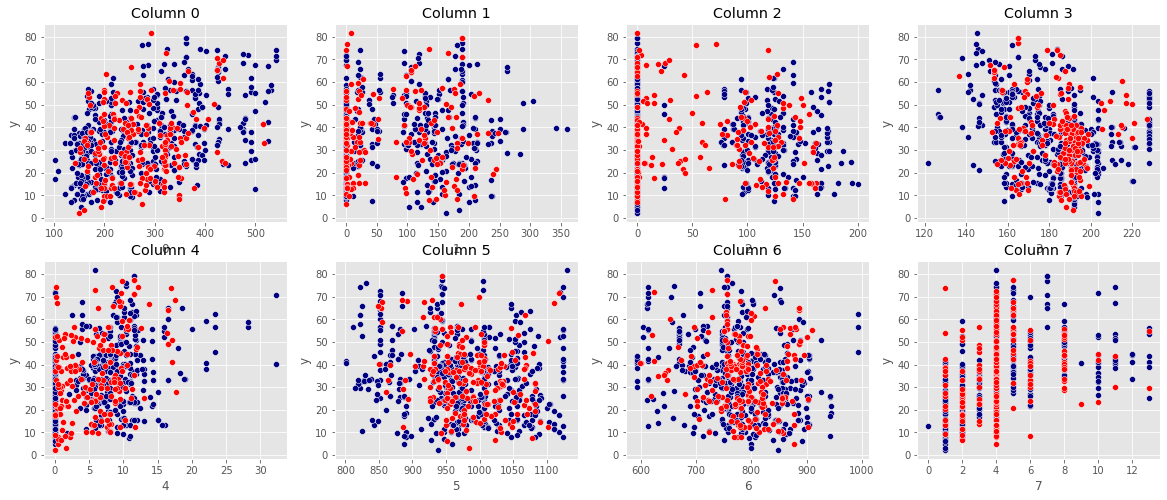

In [34]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 8))
df = train_KNNfill['data1']
df_na = train_data['data1'].isnull()

for i in range(df.shape[1]-1):
    is_na = np.where(df_na.iloc[:, i]==True)
    not_na = np.where(df_na.iloc[:, i]==False)
    ax1 = sns.scatterplot(x=df.loc[not_na, i], y=df.loc[not_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="navy")
    ax1 = sns.scatterplot(x=df.loc[is_na, i], y=df.loc[is_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="red")
    ax1.set_title("Column {}".format(i))
    ax1.set_ylabel("y")

### Data 2

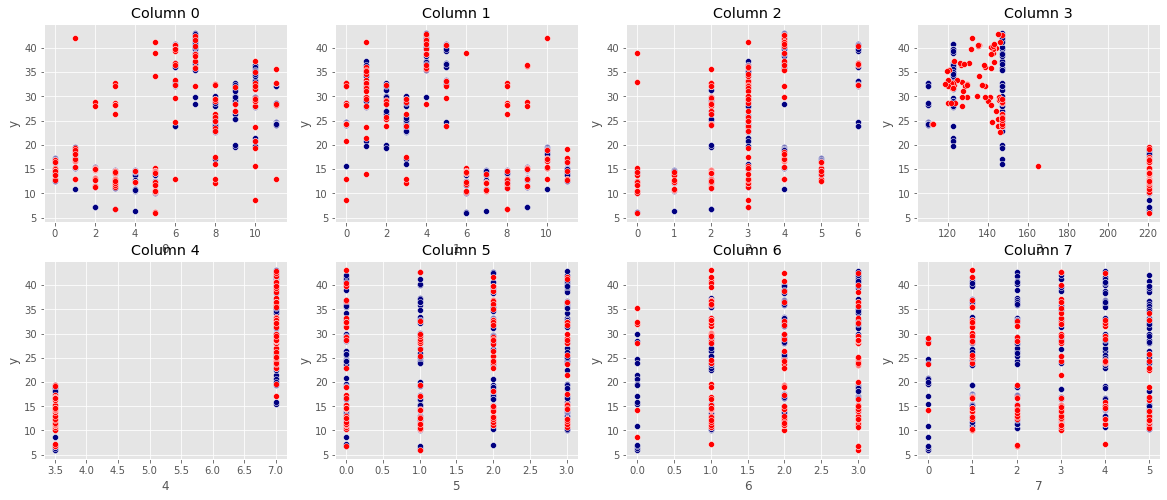

In [35]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 8))
df = train_KNNfill['data2']
df_na = train_data['data2'].isnull()

for i in range(df.shape[1]-1):
    is_na = np.where(df_na.iloc[:, i]==True)
    not_na = np.where(df_na.iloc[:, i]==False)
    ax1 = sns.scatterplot(x=df.loc[not_na, i], y=df.loc[not_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="navy")
    ax1 = sns.scatterplot(x=df.loc[is_na, i], y=df.loc[is_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="red")
    ax1.set_title("Column {}".format(i))
    ax1.set_ylabel("y")

### Data 3

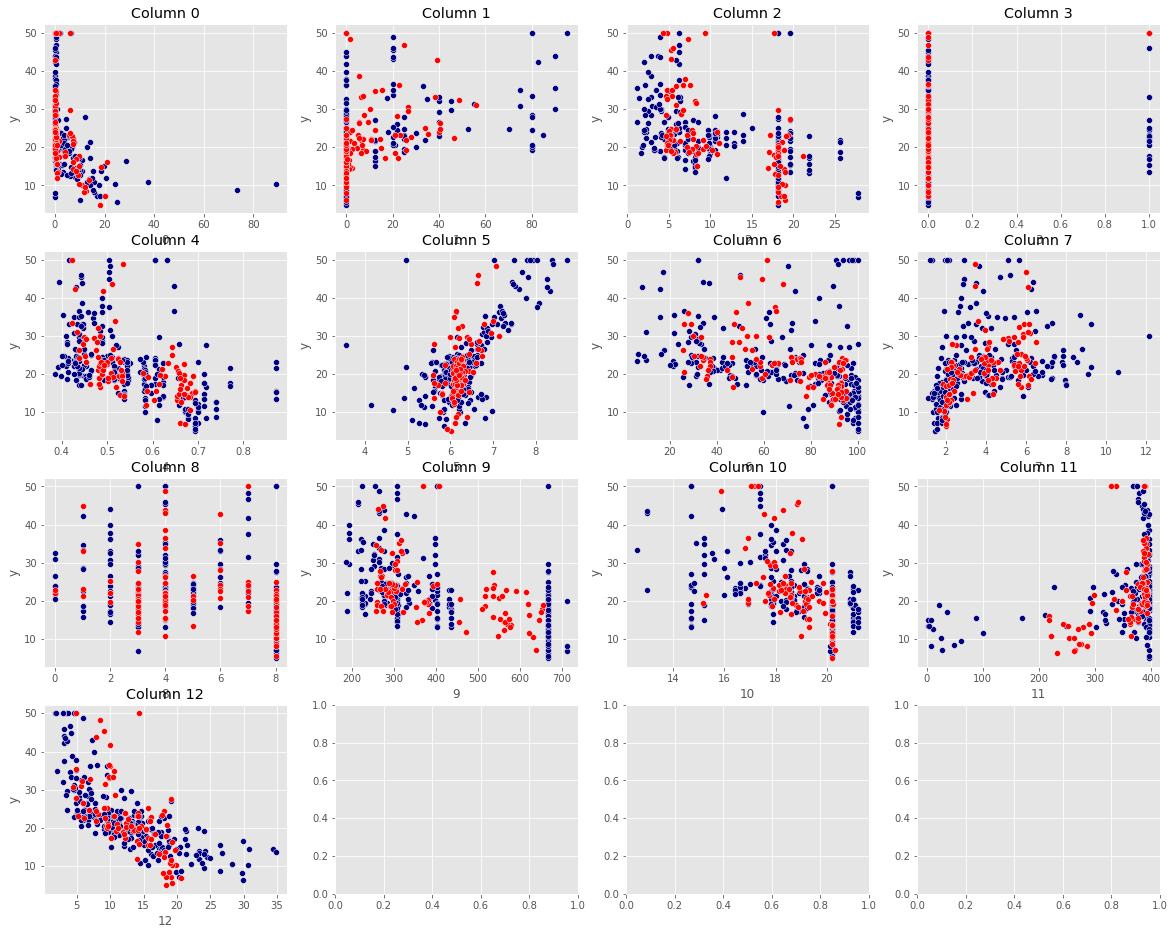

In [36]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (20, 16))
df = train_KNNfill['data3']
df_na = train_data['data3'].isnull()

for i in range(df.shape[1]-1):
    is_na = np.where(df_na.iloc[:, i]==True)
    not_na = np.where(df_na.iloc[:, i]==False)
    ax1 = sns.scatterplot(x=df.loc[not_na, i], y=df.loc[not_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="navy")
    ax1 = sns.scatterplot(x=df.loc[is_na, i], y=df.loc[is_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="red")
    ax1.set_title("Column {}".format(i))
    ax1.set_ylabel("y")

### Data 4

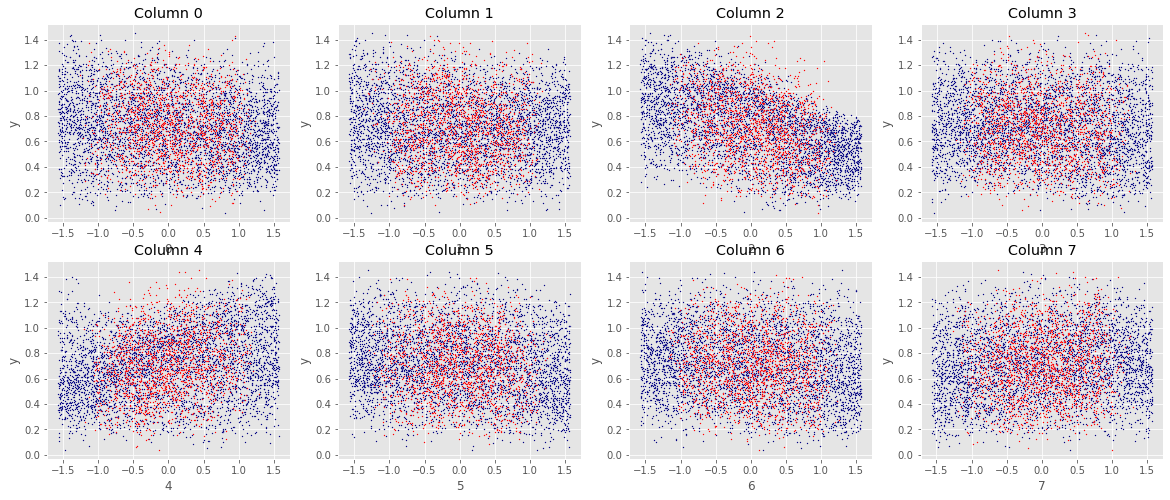

In [37]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 8))
df = train_KNNfill['data4']
df_na = train_data['data4'].isnull()

for i in range(df.shape[1]-1):
    is_na = np.where(df_na.iloc[:, i]==True)
    not_na = np.where(df_na.iloc[:, i]==False)
    ax1 = sns.scatterplot(x=df.loc[not_na, i], y=df.loc[not_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="navy", s=2)
    ax1 = sns.scatterplot(x=df.loc[is_na, i], y=df.loc[is_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="red", s=2)
    ax1.set_title("Column {}".format(i))
    ax1.set_ylabel("y")

### Data 5

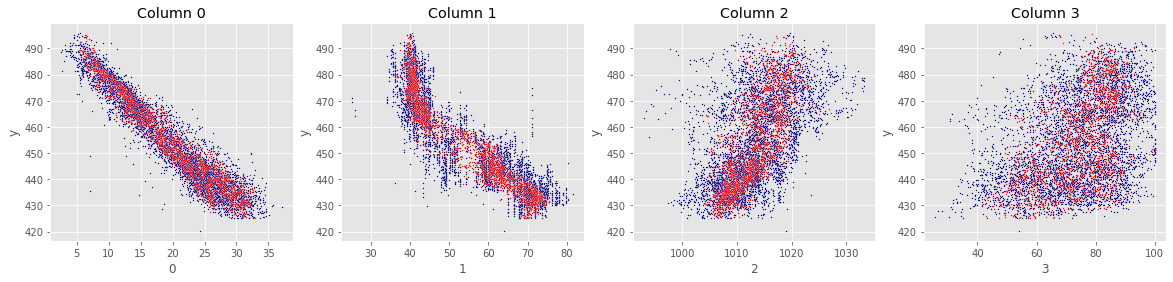

In [38]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 4))
df = train_KNNfill['data5']
df_na = train_data['data5'].isnull()

for i in range(df.shape[1]-1):
    is_na = np.where(df_na.iloc[:, i]==True)
    not_na = np.where(df_na.iloc[:, i]==False)
    ax1 = sns.scatterplot(x=df.loc[not_na, i], y=df.loc[not_na, df.shape[1]-1], 
                          ax=axes[i%4], color="navy", s=2)
    ax1 = sns.scatterplot(x=df.loc[is_na, i], y=df.loc[is_na, df.shape[1]-1], 
                          ax=axes[i%4], color="red", s=2)
    ax1.set_title("Column {}".format(i))
    ax1.set_ylabel("y")

### Data 6

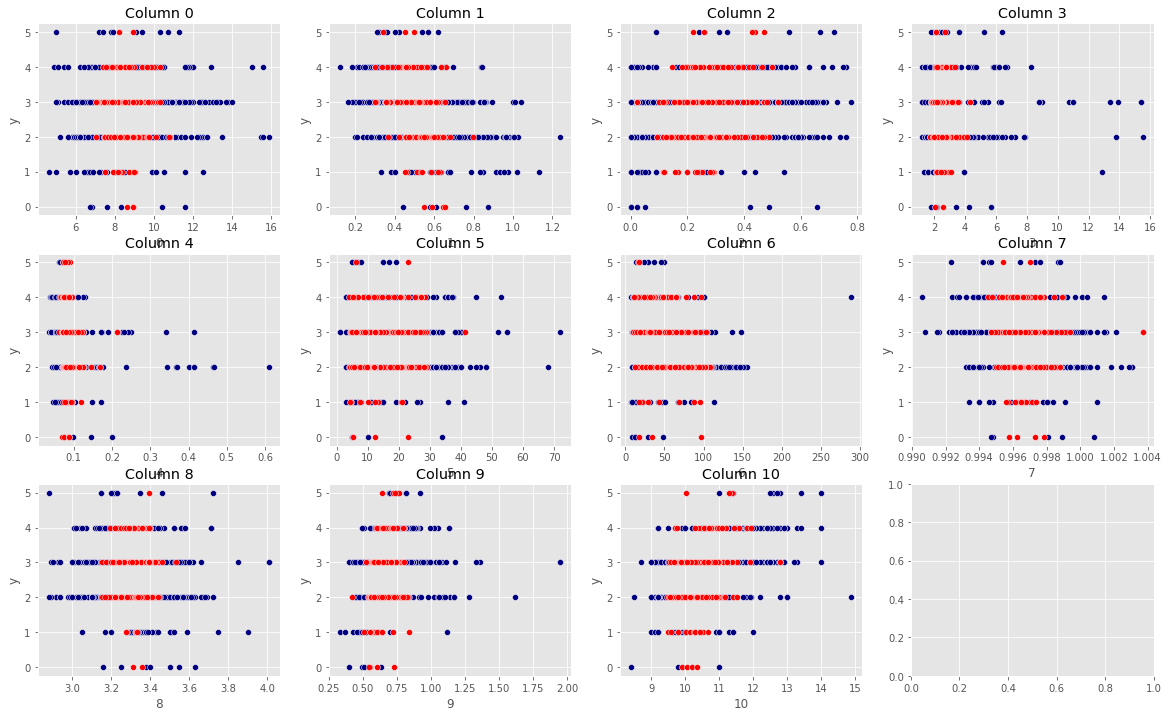

In [39]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize = (20, 12))
df = train_KNNfill['data6']
df_na = train_data['data6'].isnull()

for i in range(df.shape[1]-1):
    is_na = np.where(df_na.iloc[:, i]==True)
    not_na = np.where(df_na.iloc[:, i]==False)
    ax1 = sns.scatterplot(x=df.loc[not_na, i], y=df.loc[not_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="navy")
    ax1 = sns.scatterplot(x=df.loc[is_na, i], y=df.loc[is_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="red")
    ax1.set_title("Column {}".format(i))
    ax1.set_ylabel("y")

### Data 7

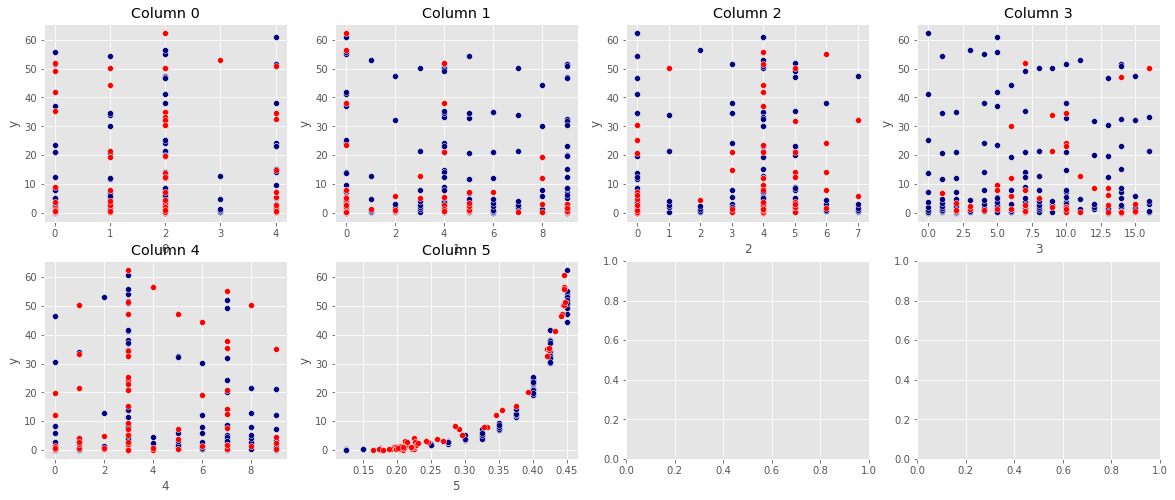

In [40]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 8))
df = train_KNNfill['data7']
df_na = train_data['data7'].isnull()

for i in range(df.shape[1]-1):
    is_na = np.where(df_na.iloc[:, i]==True)
    not_na = np.where(df_na.iloc[:, i]==False)
    ax1 = sns.scatterplot(x=df.loc[not_na, i], y=df.loc[not_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="navy")
    ax1 = sns.scatterplot(x=df.loc[is_na, i], y=df.loc[is_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="red")
    ax1.set_title("Column {}".format(i))
    ax1.set_ylabel("y")

###  Model

In [41]:
from sklearn.model_selection import train_test_split  # 資料分割
from sklearn.metrics import mean_squared_error  # 模型評估

In [42]:
from xgboost import XGBRegressor, XGBClassifier
ans_KNN = []

for data in train_KNNfill:
    print("**Here is", data)
    data_X = train_KNNfill[data].iloc[:, :-1]
    data_y = train_KNNfill[data].iloc[:, -1]
    test_data_X  = test_KNNfill[data].iloc[:, :-1]
    
    #splitting train and test data 
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2)
    # Create the model
    if data_y.nunique() < 20 :
        clf = XGBClassifier(max_depth=5, 
                            eval_metric=['logloss', 'auc', 'error'],
                            objective='binary:logistic',
                            use_label_encoder=False)
    else:
        clf = XGBRegressor(n_estimators=100)
    # Learn the digits on the train subset
    clf.fit(X_train, y_train)
    # Predict the value of the digit on the validation subset
    y_pred = clf.predict(X_test)
    
    MSE = mean_squared_error(y_test, y_pred)
    print("MSE : {:.5}\n".format(MSE))    
    
    # Predict the value of test data
    test_y_pred = clf.predict(test_data_X)
    ans_KNN.append(test_y_pred)

**Here is data1
MSE : 103.49

**Here is data2
MSE : 5.394

**Here is data3
MSE : 16.415

**Here is data4
MSE : 0.044016

**Here is data5
MSE : 12.991

**Here is data6
MSE : 0.66516

**Here is data7
MSE : 2.7424



### 資料轉回 & 輸出

In [43]:
label_dict_reverse = {}
for data in label_dict:
    label_dict_reverse[data] = {}
    for col in label_dict[data]:
        label_dict_reverse[data][col] = {key: value for (value, key) in label_dict[data][col].items()}

def reverse_label_encording(filled_data):
    for i, data in enumerate(filled_data):
        print(data)
        df = filled_data[data].copy()
        for col in label_col[data]:
            label_transfer_list = label_dict_reverse[data]['col{}'.format(col)]
            filled_data[data].iloc[:, col] = df.iloc[:, col].replace(label_transfer_list)
    return filled_data

def write_csv(filled_data, ans_list, upload_num):
    for i, data in enumerate(filled_data):
        df = filled_data[data].copy()
        df.iloc[:, -1] = ans_list[i]
        df.to_csv("./upload/upload_{}/{}_upload.csv".format(upload_num, data), 
                  header=None, index=False) 

In [44]:
test_KNNfill = reverse_label_encording(test_KNNfill)
#write_csv(test_KNNfill, ans_KNN, 6)

data1
data2
data3
data4
data5
data6
data7


### Result
沒上傳

## xgboost
- [XGBRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor)
- [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)

In [45]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from xgboost import XGBRegressor, XGBClassifier

# construct model
imputer_Regressor = IterativeImputer(estimator=XGBRegressor(n_estimators=100), 
                                     random_state=0, max_iter=30)

imputer_Classifier = IterativeImputer(estimator=XGBClassifier(max_depth=5, 
                                                       eval_metric=['logloss', 'auc', 'error'],
                                                       objective='binary:logistic',
                                                       use_label_encoder=False), 
                                      random_state=0, max_iter=30)

train_XGBfill, test_XGBfill = {}, {}
for data in train_data:
    print(data)
    # 引入需要處理的 data 資料
    df, df_test = train_data[data].copy(), test_data[data].copy()
    r_index, c_index = non_label_col[data], label_col[data]
    y_index = df.shape[1]-1
    

    # 從兩個 index 中移除最後一欄 y
    r_index = [x for x in r_index if x!=(y_index)]
    c_index = [x for x in c_index if x!=(y_index)]
    
    # 如果 category 多過 continuous, 那就先填 category 的 NA
    # 接著用全部資料執行 Regressor
    if len(c_index) > len(r_index): 
        if c_index != []: 
            print('* Do the Classification. -- train')
            df_X = df.iloc[:, c_index]
            imputer_Classifier.fit(df_X)  # 使用 train data 去 fit  
            df_impute = pd.DataFrame(imputer_Classifier.transform(df_X))
            for i in range(len(c_index)):
                df.iloc[:, c_index[i]] = df_impute.iloc[:, i]
            
            print('* Do the Classification. -- test')
            imputer_Classifier.fit(df.iloc[:, c_index])  # 使用填好的 train data 去 refit  
            df_Xt = df_test.iloc[:, c_index]
            df_impute = pd.DataFrame(imputer_Classifier.transform(df_Xt))
            for i in range(len(c_index)):
                df_test.iloc[:, c_index[i]] = df_impute.iloc[:, i]
        
        if r_index != []: 
            print('* Do the Regression. -- train')
            #df_X = df.iloc[:, :-1]  
            imputer_Regressor.fit(df)   # 使用全部的 train data 去 fit  
            df_impute = pd.DataFrame(imputer_Regressor.transform(df))
            for i in range(len(r_index)):
                df.iloc[:, r_index[i]] = df_impute.iloc[:, r_index[i]]
            
            print('* Do the Regression. -- test')
            imputer_Regressor.fit(df.iloc[:, :-1])  # 使用填好的 train data 去 refit  
            df_Xt = df_test.iloc[:, :-1]
            df_impute = pd.DataFrame(imputer_Regressor.transform(df_Xt))
            for i in range(len(r_index)):
                df_test.iloc[:, r_index[i]] = df_impute.iloc[:, r_index[i]]   
    
    # 如果 continuous 多過 category , 那就先填 continuous 的 NA
    # 接著用全部資料執行 category 預測
    elif len(r_index) > len(c_index): 
        if r_index != []: 
            print('* Do the Regression. -- train')
            df_X = df.iloc[:, r_index+[y_index]] # 加入 y 欄位
            imputer_Regressor.fit(df_X)  # 使用 train data 去 fit  
            df_impute = pd.DataFrame(imputer_Regressor.transform(df_X))
            for i in range(len(r_index)):
                df.iloc[:, r_index[i]] = df_impute.iloc[:, i]

            print('* Do the Regression. -- test')
            imputer_Regressor.fit(df.iloc[:, r_index])  # 使用 train data 去 fit  
            df_X = df_test.iloc[:, r_index]
            df_impute = pd.DataFrame(imputer_Regressor.transform(df_X))
            for i in range(len(r_index)):
                df_test.iloc[:, r_index[i]] = df_impute.iloc[:, i]

        if c_index != []: 
            print('* Do the Classification. -- train & test')
            for col in c_index:
                # for train data
                df_X = df.iloc[:, r_index+[y_index]]
                df_y = df.iloc[:, col]
                train_index = np.where(df_y.isnull()==False)[0]
                test_index = np.where(df_y.isnull())[0]
                
                # construct classify model
                clf = XGBClassifier(max_depth=5, 
                    eval_metric=['logloss', 'auc', 'error'],
                    objective='binary:logistic',
                    use_label_encoder=False)

                try: #防故障用
                    clf.fit(df_X.iloc[train_index, :], df_y[train_index])
                except:
                    xgb_param = clf.get_xgb_params() 
                    xgb_param['num_class'] = 2
                    clf = clf(xgb_param) 
                
                nan_pred = clf.predict(df_X.iloc[test_index, :])
                df_y[test_index] = nan_pred # 將nan位置填值
                df.iloc[:, col] = df_y

                # for test data
                df_Xt = df_test.iloc[:, r_index]
                df_yt = df_test.iloc[:, col]
                test_index = np.where(df_yt.isnull())[0]
                clf.fit(df.iloc[train_index, r_index], df_y[train_index])  # refit
                nan_pred = clf.predict(df_Xt.iloc[test_index, :])
                df_yt[test_index] = nan_pred # 將nan位置填值
                df_test.iloc[:, col] = df_yt

    train_XGBfill[data] = df
    test_XGBfill[data] = df_test

data1
* Do the Regression. -- train


C:\Users\Rou_yi\AppData\Roaming\Python\Python38\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


* Do the Regression. -- test
* Do the Classification. -- train & test
data2
* Do the Classification. -- train


C:\Users\Rou_yi\AppData\Roaming\Python\Python38\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


* Do the Classification. -- test
* Do the Regression. -- train
* Do the Regression. -- test
data3
* Do the Regression. -- train


C:\Users\Rou_yi\AppData\Roaming\Python\Python38\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


* Do the Regression. -- test
* Do the Classification. -- train & test
data4
* Do the Regression. -- train


C:\Users\Rou_yi\AppData\Roaming\Python\Python38\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


* Do the Regression. -- test
data5
* Do the Regression. -- train


C:\Users\Rou_yi\AppData\Roaming\Python\Python38\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


* Do the Regression. -- test
data6
* Do the Regression. -- train


C:\Users\Rou_yi\AppData\Roaming\Python\Python38\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


* Do the Regression. -- test
data7
* Do the Classification. -- train
* Do the Classification. -- test
* Do the Regression. -- train
* Do the Regression. -- test


### Data 1

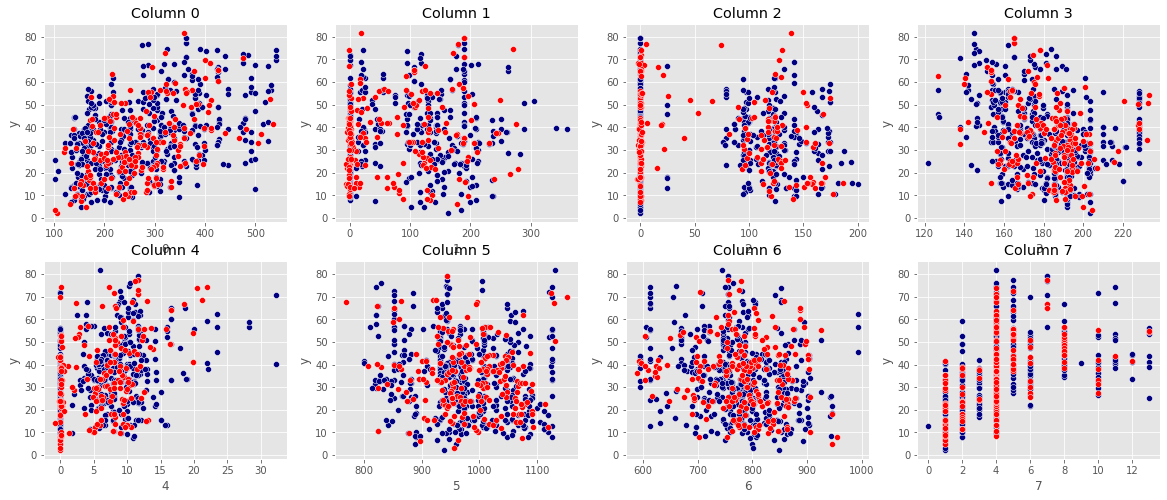

In [46]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 8))
df = train_XGBfill['data1']
df_na = train_data['data1'].isnull()

for i in range(df.shape[1]-1):
    is_na = np.where(df_na.iloc[:, i]==True)
    not_na = np.where(df_na.iloc[:, i]==False)
    ax1 = sns.scatterplot(x=df.loc[not_na, i], y=df.loc[not_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="navy")
    ax1 = sns.scatterplot(x=df.loc[is_na, i], y=df.loc[is_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="red")
    ax1.set_title("Column {}".format(i))
    ax1.set_ylabel("y")

### Data 2

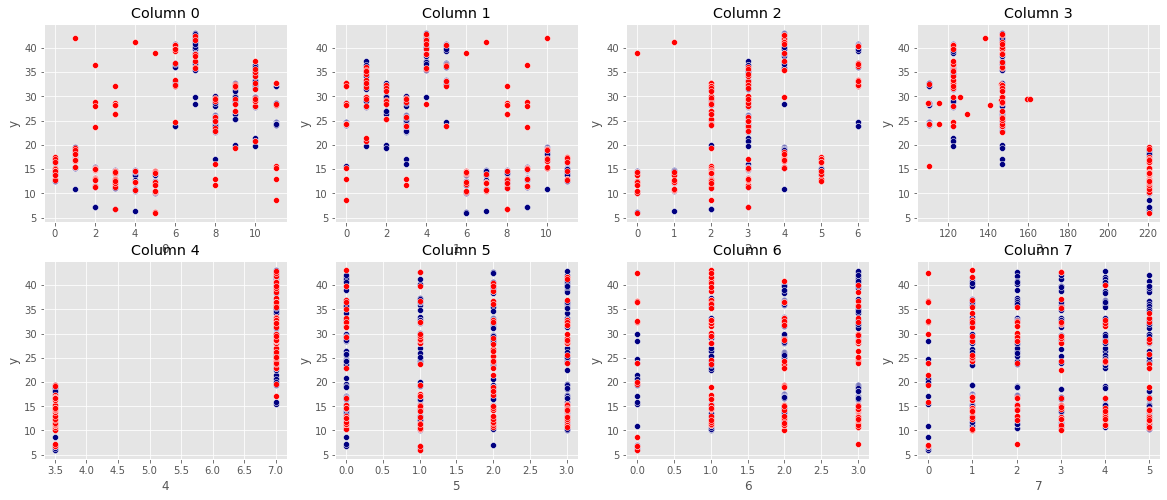

In [47]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 8))
df = train_XGBfill['data2']
df_na = train_data['data2'].isnull()

for i in range(df.shape[1]-1):
    is_na = np.where(df_na.iloc[:, i]==True)
    not_na = np.where(df_na.iloc[:, i]==False)
    ax1 = sns.scatterplot(x=df.loc[not_na, i], y=df.loc[not_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="navy")
    ax1 = sns.scatterplot(x=df.loc[is_na, i], y=df.loc[is_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="red")
    ax1.set_title("Column {}".format(i))
    ax1.set_ylabel("y")

### Data 3

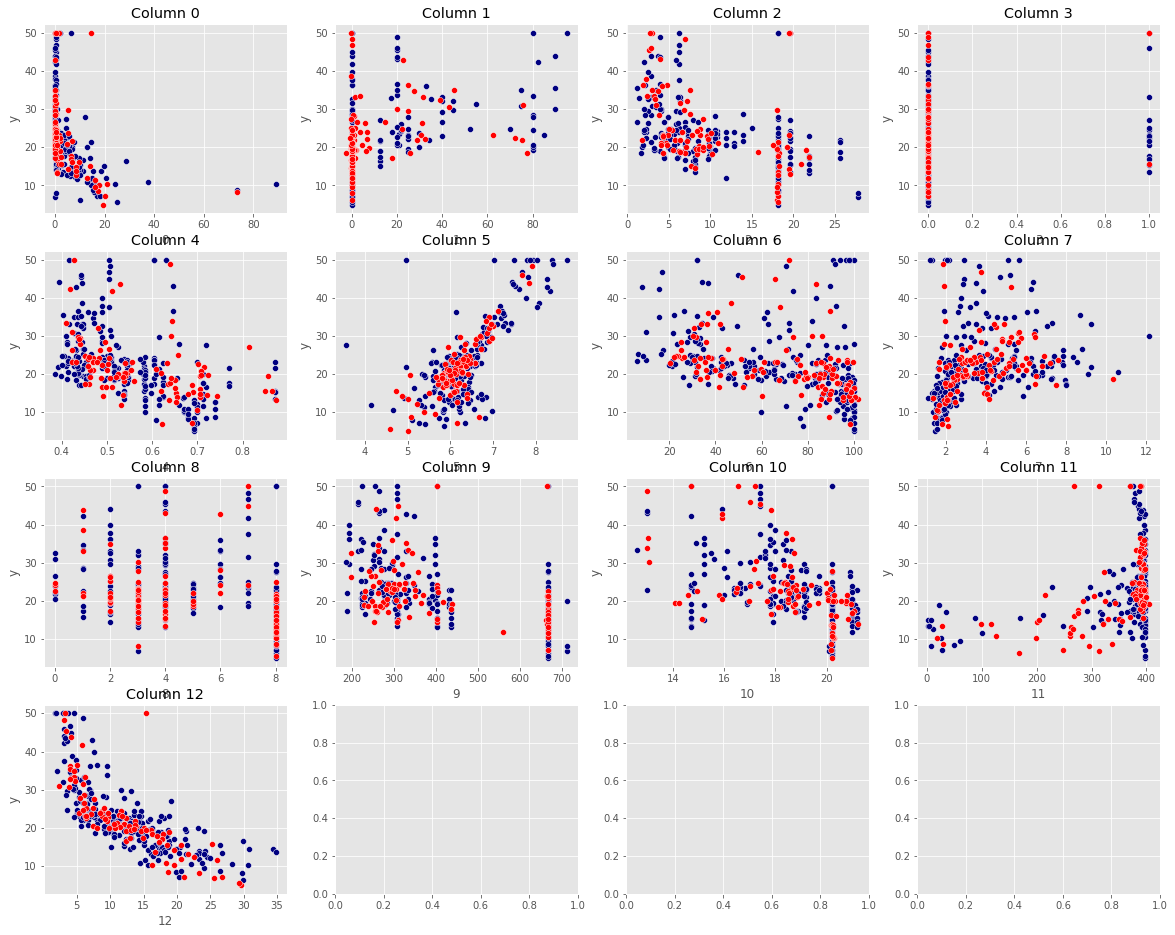

In [48]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (20, 16))
df = train_XGBfill['data3']
df_na = train_data['data3'].isnull()

for i in range(df.shape[1]-1):
    is_na = np.where(df_na.iloc[:, i]==True)
    not_na = np.where(df_na.iloc[:, i]==False)
    ax1 = sns.scatterplot(x=df.loc[not_na, i], y=df.loc[not_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="navy")
    ax1 = sns.scatterplot(x=df.loc[is_na, i], y=df.loc[is_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="red")
    ax1.set_title("Column {}".format(i))
    ax1.set_ylabel("y")

### Data 4

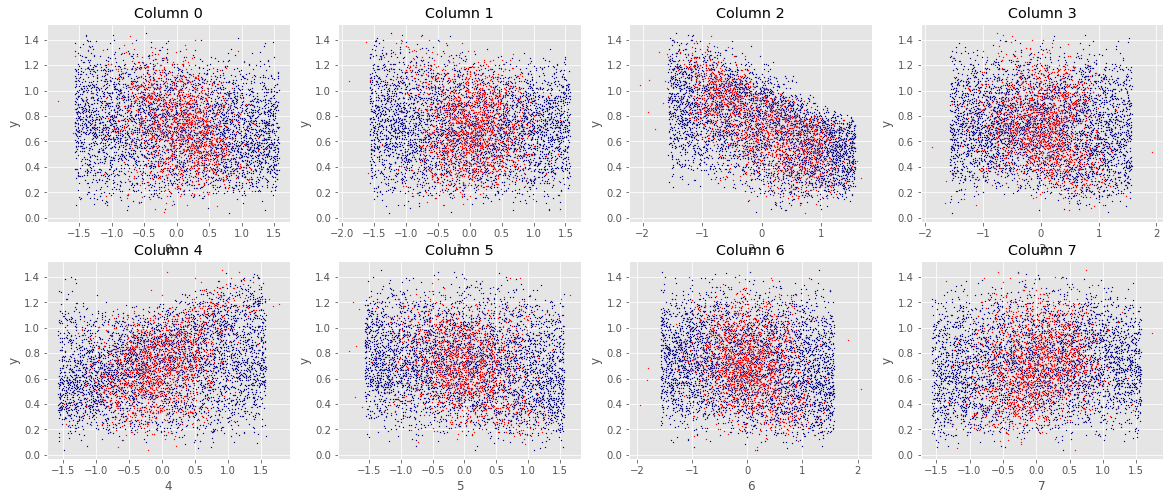

In [49]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 8))
df = train_XGBfill['data4']
df_na = train_data['data4'].isnull()

for i in range(df.shape[1]-1):
    is_na = np.where(df_na.iloc[:, i]==True)
    not_na = np.where(df_na.iloc[:, i]==False)
    ax1 = sns.scatterplot(x=df.loc[not_na, i], y=df.loc[not_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="navy", s=2)
    ax1 = sns.scatterplot(x=df.loc[is_na, i], y=df.loc[is_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="red", s=2)
    ax1.set_title("Column {}".format(i))
    ax1.set_ylabel("y")

### Data 5

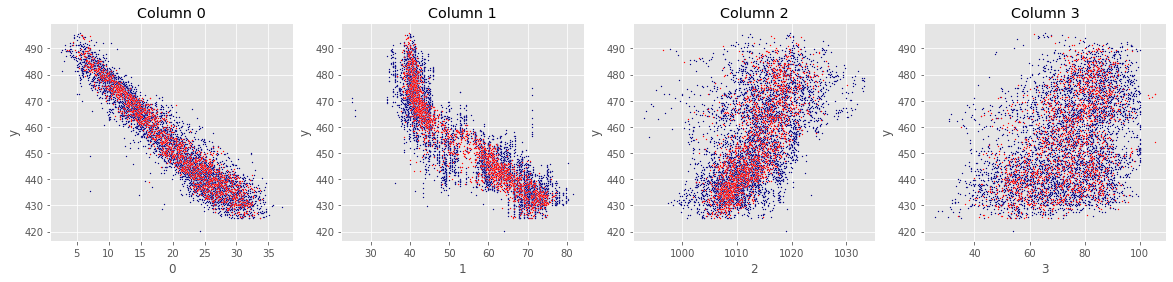

In [50]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 4))
df = train_XGBfill['data5']
df_na = train_data['data5'].isnull()

for i in range(df.shape[1]-1):
    is_na = np.where(df_na.iloc[:, i]==True)
    not_na = np.where(df_na.iloc[:, i]==False)
    ax1 = sns.scatterplot(x=df.loc[not_na, i], y=df.loc[not_na, df.shape[1]-1], 
                          ax=axes[i%4], color="navy", s=2)
    ax1 = sns.scatterplot(x=df.loc[is_na, i], y=df.loc[is_na, df.shape[1]-1], 
                          ax=axes[i%4], color="red", s=2)
    ax1.set_title("Column {}".format(i))
    ax1.set_ylabel("y")

### Data 6

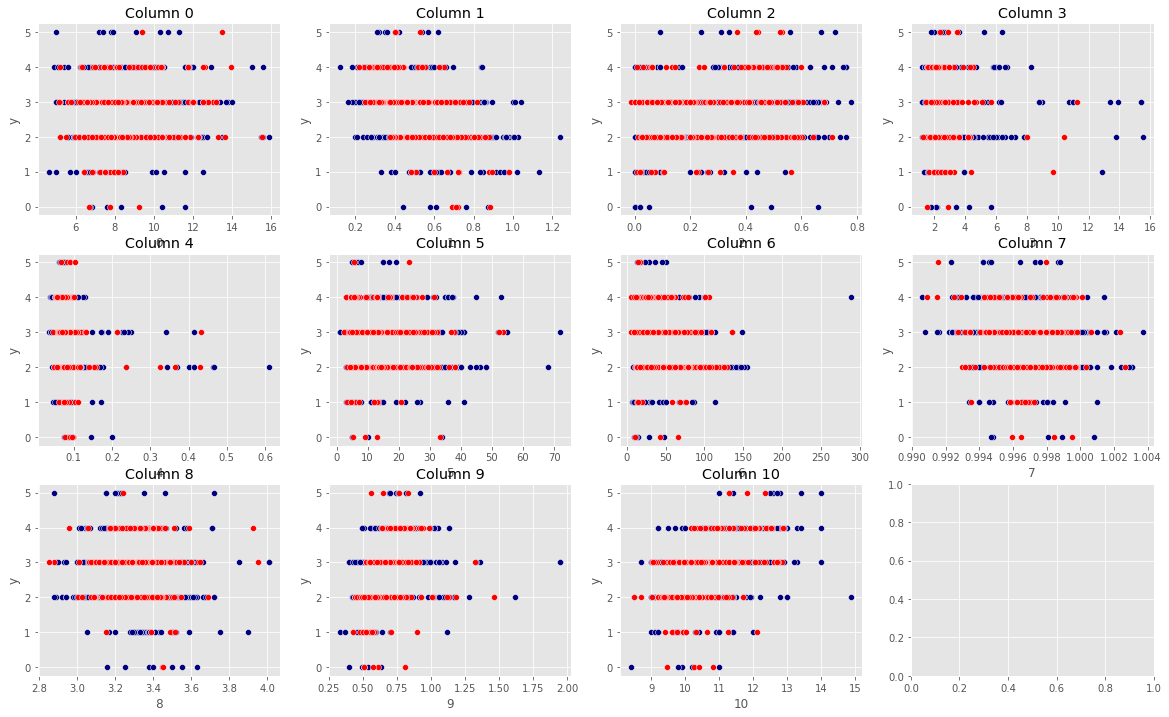

In [51]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize = (20, 12))
df = train_XGBfill['data6']
df_na = train_data['data6'].isnull()

for i in range(df.shape[1]-1):
    is_na = np.where(df_na.iloc[:, i]==True)
    not_na = np.where(df_na.iloc[:, i]==False)
    ax1 = sns.scatterplot(x=df.loc[not_na, i], y=df.loc[not_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="navy")
    ax1 = sns.scatterplot(x=df.loc[is_na, i], y=df.loc[is_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="red")
    ax1.set_title("Column {}".format(i))
    ax1.set_ylabel("y")

### Data 7

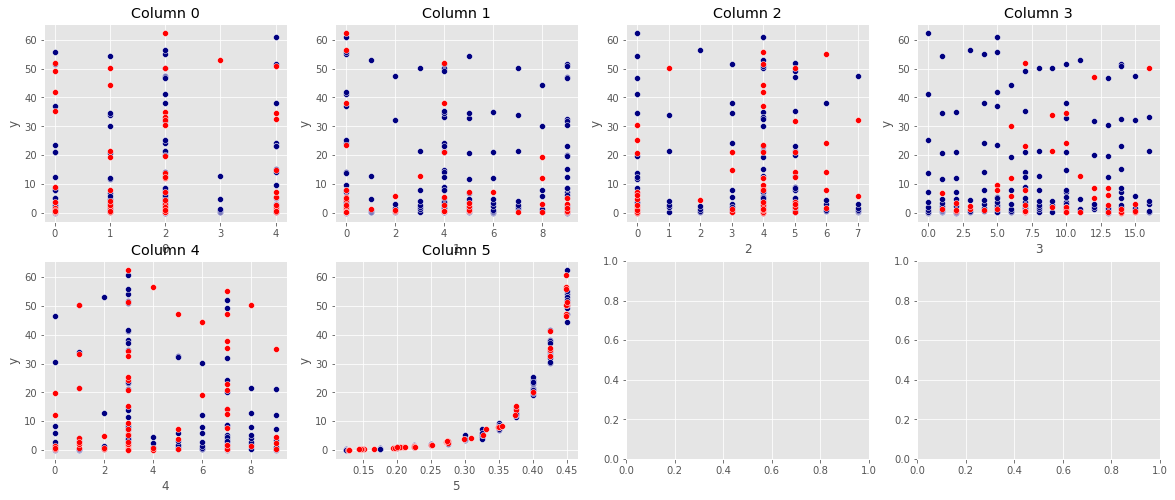

In [52]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 8))
df = train_XGBfill['data7']
df_na = train_data['data7'].isnull()

for i in range(df.shape[1]-1):
    is_na = np.where(df_na.iloc[:, i]==True)
    not_na = np.where(df_na.iloc[:, i]==False)
    ax1 = sns.scatterplot(x=df.loc[not_na, i], y=df.loc[not_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="navy")
    ax1 = sns.scatterplot(x=df.loc[is_na, i], y=df.loc[is_na, df.shape[1]-1], 
                          ax=axes[i//4][i%4], color="red")
    ax1.set_title("Column {}".format(i))
    ax1.set_ylabel("y")

###  Model

In [53]:
from sklearn.model_selection import train_test_split  # 資料分割
from sklearn.metrics import mean_squared_error  # 模型評估

In [54]:
from xgboost import XGBRegressor, XGBClassifier
ans_XGB = []

for data in train_XGBfill:
    print("**Here is", data)
    data_X = train_XGBfill[data].iloc[:, :-1]
    data_y = train_XGBfill[data].iloc[:, -1]
    test_data_X  = test_XGBfill[data].iloc[:, :-1]
    
    #splitting train and test data 
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2)
    # Create the model
    if data_y.nunique() < 20 :
        clf = XGBClassifier(max_depth=5, 
                            eval_metric=['logloss', 'auc', 'error'],
                            objective='binary:logistic',
                            use_label_encoder=False)
    else:
        clf = XGBRegressor(n_estimators=100)
    # Learn the digits on the train subset
    clf.fit(X_train, y_train)
    # Predict the value of the digit on the validation subset
    y_pred = clf.predict(X_test)
    
    MSE = mean_squared_error(y_test, y_pred)
    print("MSE : {:.5}\n".format(MSE))    
    
    # Predict the value of test data
    test_y_pred = clf.predict(test_data_X)
    ans_XGB.append(test_y_pred)

**Here is data1
MSE : 59.553

**Here is data2
MSE : 7.682

**Here is data3
MSE : 6.102

**Here is data4
MSE : 0.018958

**Here is data5
MSE : 13.814

**Here is data6
MSE : 0.50679

**Here is data7
MSE : 2.7335



### 資料轉回 & 輸出

In [55]:
test_reverse = reverse_label_encording(test_XGBfill)
#write_csv(test_reverse, ans_XGB, 8)

data1
data2
data3
data4
data5
data6
data7


### Result
upload 8 --- MP_mean: 151.7696 / TP_mean: 30.2521

